# 4. Reconstruction from features

After retrieving the most relevant features with an ICA from the scattering
coefficients, we can now check what these features are actually telling us. So
far, they seem abstract and have no physical unit. However, we can understand
better the features, if we look on how they are constructed and how they would
reconstruct its input, the scattering coefficients. This strategy was mainly
discussed in this [paper](https://doi.org/10.1029/2022GL098854), where we can
track the superficial freezing and thawing process on a single indepedent
component.

Made in 2022 by René Steinmann and Léonard Seydoux.

This notebook uses the __matplotlib__ and __scikit-learn__ library, please run the cell below if the packages are not installed.

In [1]:
# %pip install matplotlib
# %pip install scikit-learn

In [12]:
import pickle

import numpy as np
import matplotlib.pylab as plt

plt.rcParams["date.converter"] = "concise"

## Load the data
For this notebook we need to load the scattering network model, the dimensionality reduction model and the independent components.

In [13]:
# Load the scattering network
network = pickle.load(open("GL_scattering_network.pickle", "rb"))

# Load the dimensionality reduction model
dimension_model = pickle.load(open("GL_dimension_model.pickle", "rb"))

# Load data from file
with np.load("GL_independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

## Feature

FastICA finds a set of independent components $\mathbf{s}$ by multiplying an unmixing matrix $\mathbf{W}$ to the scattering coefficients stored in the matrix $\mathbf{x}$: 

$$\mathbf{s} = \mathbf{W} \mathbf{x}$$

The FastICA model stores the unmixing matrix $\mathbf{W}$ in the attribute ``.components_`` (more information on [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA)). We can extract the weights of the unmixing matrix and visualize it to understand better what each indepedent component 'means', since it connects the scattering coefficients to the independent components.
To give an example on how to use the information of the unmixing matrix, we will
choose one single independent component and extract the unmixing weights for
that component.

### Extract feature evolution

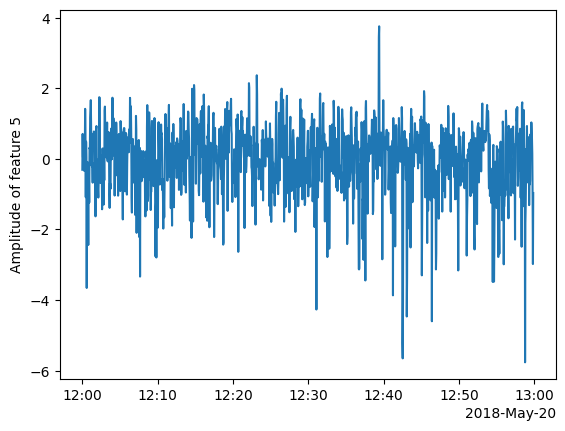

In [14]:
# Pick a feature
feature_id = 5
feature = features[:, feature_id]

# Figure creation
fig = plt.figure()
ax = plt.axes()

# Plot the weights
ax.plot(times[:-1], feature)
ax.set_ylabel(f"Amplitude of feature {feature_id}")

# Show
plt.show()

### Feature direction in the scattering space

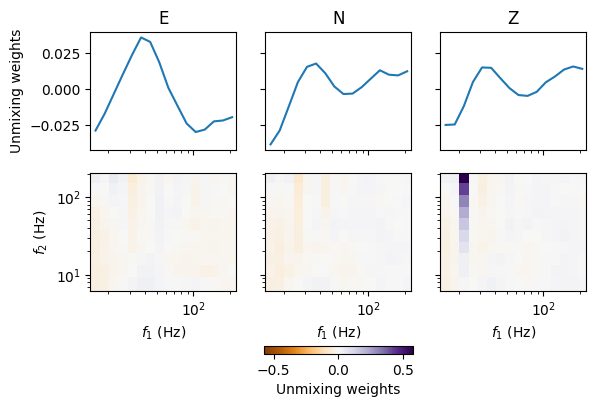

In [15]:
# Etract weights from the dimensionality reduction model
weights = dimension_model.components_[feature_id]
vmax = np.abs(weights).max()

# Scattering coefficients shape and frequencies
n_cha = 3
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
n_order_2 = network.banks[1].octaves * network.banks[1].resolution
f_1 = network.banks[0].centers
f_2 = network.banks[1].centers

# Extract and reshape weights
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)
order_2 = weights[n_cha * n_order_1 :].reshape(n_cha, n_order_1, n_order_2)

# Show weights
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey="row")
image_kw = dict(vmin=-vmax, vmax=vmax, rasterized=True, cmap="PuOr")
for id, channel in enumerate("ENZ"):

    # Show
    ax[0, id].plot(f_1, order_1[id], label=channel)
    mappable = ax[1, id].pcolormesh(f_1, f_2, order_2[id].T, **image_kw)

    # Labels
    ax[0, id].set_title(channel)
    ax[1, id].set_xlabel("$f_1$ (Hz)")

# Labels
ax[0, 0].set_ylabel("Unmixing weights")
ax[1, 0].set_ylabel("$f_2$ (Hz)")
ax[1, 0].set_xscale("log")
ax[1, 0].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="horizontal", ax=ax, shrink=0.3)
colorbar.set_label("Unmixing weights")

# Show
plt.show()

## Reconstruction

We here reconstruct the scattering coefficients from a selected independent
components. We only show the first order coefficients, since the second order
coefficients are hard to map as a function of time. 

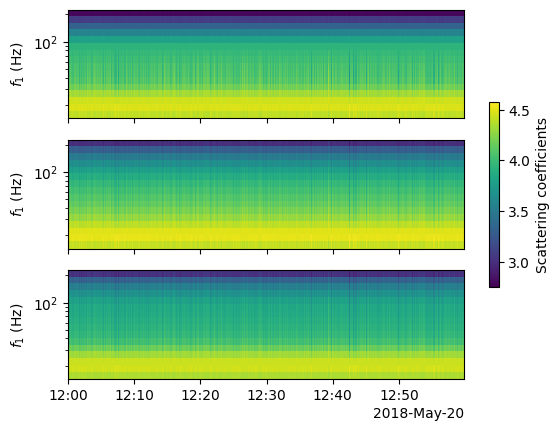

In [16]:
# Filter out latent space
features_filtered = np.zeros(features.shape)
features_filtered[:, feature_id] = feature

# Extract all scattering coefficients
reconstructed = dimension_model.inverse_transform(features_filtered)
reconstructed_order_1 = reconstructed[:, : n_cha * n_order_1].reshape(-1, n_cha, n_order_1)
vmin = reconstructed_order_1.min()
vmax = reconstructed_order_1.max()

# Plot
fig, ax = plt.subplots(nrows=3, sharex=True, sharey="row")

# Plot
for id, channel in enumerate("ENZ"):
    data = reconstructed_order_1[:, id, :].squeeze().T
    mappable = ax[id].pcolormesh(times[:-1], f_1, data, rasterized=True, vmin=vmin, vmax=vmax)
    ax[id].set_ylabel("$f_1$ (Hz)")
    ax[id].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="vertical", ax=ax, shrink=0.5)
colorbar.set_label("Scattering coefficients")